# Inaugural Project

Imports and set magics:

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

In [2]:
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# Question 1

We will now illustrate how the relationship between hours worked at home for females and males vary for different values of $\alpha$ and $\sigma$, assuming that the choice set is discrete in half hours.

In [3]:
model = HouseholdSpecializationModelClass() 
model.solve_discrete()

namespace(LM=4.5, HM=4.5, LF=4.5, HF=4.5)

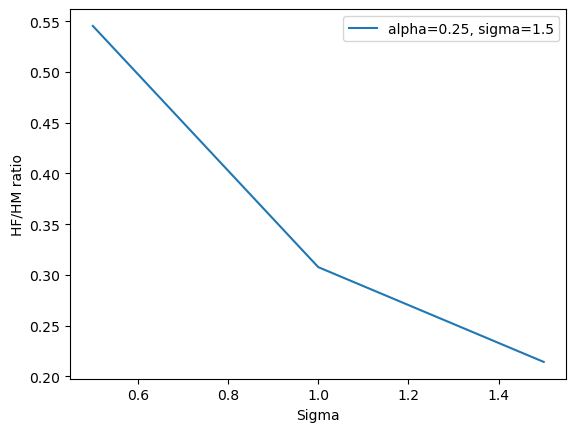

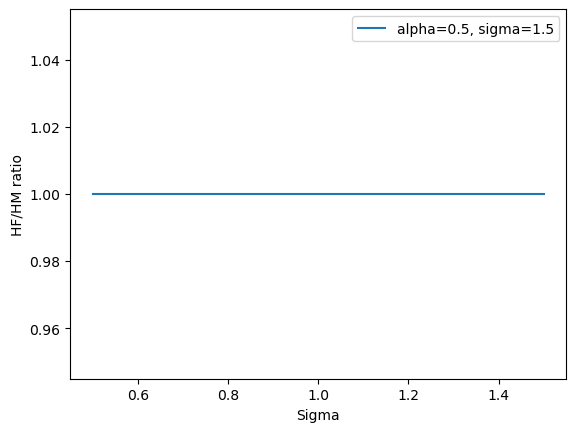

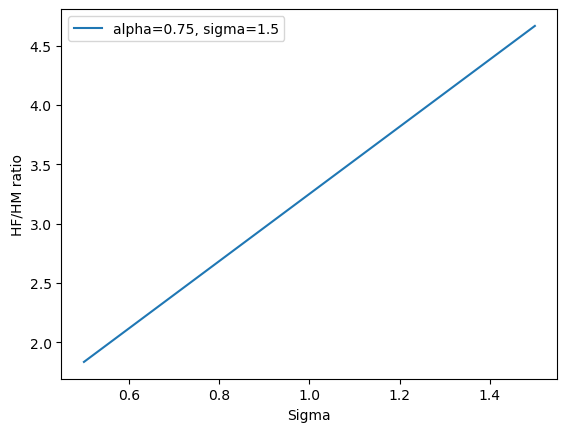

In [4]:

#parameters to loop over
# Loop over values of alpha and sigma
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1.0, 1.5]


#The model with sigma=1
model= HouseholdSpecializationModelClass()

# Define grid of values for HM
HM_vals = np.linspace(0, 24, 48)

# Loop over values of alpha and sigma
for alpha in alpha_values:
    ratios = []
    for sigma in sigma_values:
        # Update parameters
        model.par.alpha=alpha
        model.par.sigma = sigma
        # Solve model for given parameters
        opt = model.solve_discrete()
        # Ratio HF/HM for each value of HM
        ratios.append(opt.HF / opt.HM)
        # Plot results
        label=f"alpha={alpha}, sigma={sigma}"
    plt.plot(sigma_values,ratios,label=label)
    plt.xlabel('Sigma')
    plt.ylabel('HF/HM ratio')
    plt.legend()
    plt.show()
       



We find that when $\alpha$ = 0.5 males and females are equally productive, $\alpha$ > 0,5 females are more productive than males (for the same wage), and for $\alpha$ < 0,5 females are less productive than males (for the same wage).

# Question 2

Now we will plot the relationship between hours work at home between females and males, against the relationship between wages for females and males, for different values of the female wage, still assuming that the choice set is discrete.

[0.8, 0.9, 1.0, 1.1, 1.2]


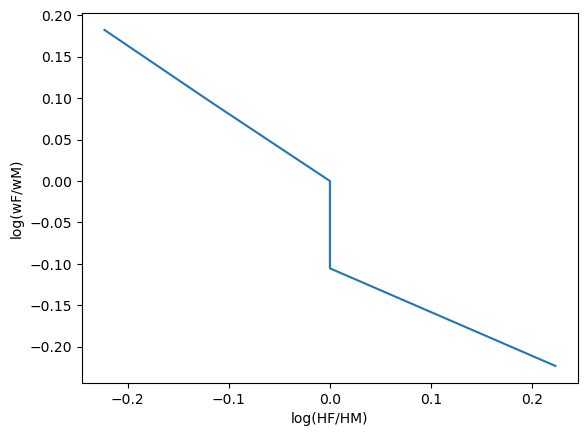

In [5]:

# Varying parameters
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]

#compute the values of HF/HM for each value of wF
model= HouseholdSpecializationModelClass()
HF_HM_values=[]
for wF in wF_values:
    model.par.wF = wF
    sol= model.solve_discrete()
    HF_HM=sol.HF/sol.HM
    HF_HM_values.append(np.log(HF_HM))


# Plot results
print(wF_values)
plt.plot(HF_HM_values,np.log(wF_values))
plt.xlabel("log(HF/HM)")
plt.ylabel("log(wF/wM)")
plt.show()


The figure shows that an increase in ${wF}/{wM}$ makes ${HF}/{HM}$ decrease. So when the wage ratio increases, female household work decreases, because then it is more profitable for females to work outside of the house rather than at home.

# Question 3

Assuming the choice set is now continuous, we will now do the same plot as in question 3. 

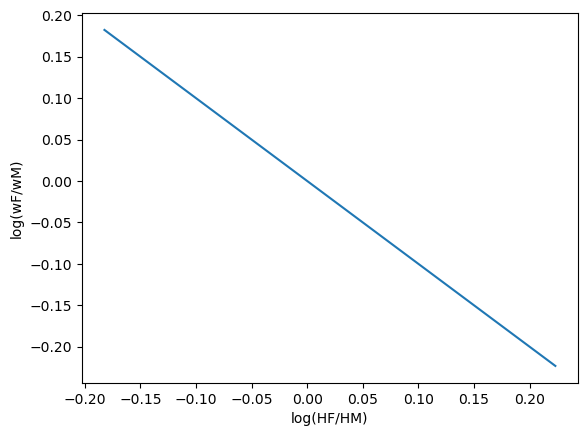

In [6]:
model3 = HouseholdSpecializationModelClass() 
model3.solve()


model3.solve_wF_vec()

#plot vector

plt.plot( np.log(model3.sol.HF_vec / model3.sol.HM_vec) , np.log(model3.par.wF_vec) ) 
plt.xlabel("log(HF/HM)")
plt.ylabel("log(wF/wM)")
plt.show()

In [7]:
model.par.wF_vec

array([0.8, 0.9, 1. , 1.1, 1.2])

The graph shows the same link as in question 2, but here it is linear. 

# Question 4

We will now solve for alpha and sigma values that minimizes $(\beta_0 - \hat{\beta_0})^2 + (\beta_1 - \hat{\beta_1})^2 $.

In [8]:
#Estimating alpha and sigma using the continously solved model
model.estimate(mode='normal', do_print=True)

#Settting alpha and sigma to the estimated values
#model.par.alpha = model.opt.alpha
#model.par.sigma = model.opt.sigma

α_opt = 0.9820154947
σ_opt = 0.0999973324
Residual_opt = 0.000000


In [9]:
model.sol.beta1

-0.10000003943587657

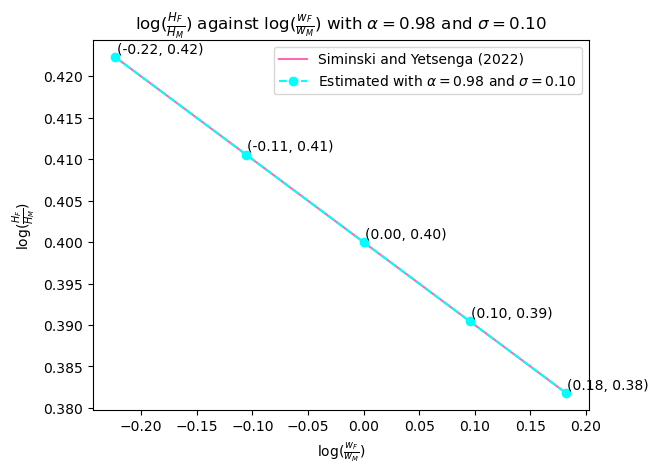

In [17]:
#Solving continously for HF/HM ratio and creating log of wFwM ratio
model.solve_wF_vec()

#Results
logHFHM_ratio_continous = np.log( model.sol.HF_vec / model.sol.HM_vec )
logwFwM_ratio = np.log(model.par.wF_vec)

#Generating line by estimates from Siminski and Yetsenga (2022)
x = np.log(np.linspace(0.8, 1.2, 2))
y = model.par.beta0_target + model.par.beta1_target*x

#Plot results 
plt.plot(x, y, color = 'hotpink', linestyle = '-', label='Siminski and Yetsenga (2022)')
plt.plot(logwFwM_ratio, logHFHM_ratio_continous, 
         marker = 'o', 
         linestyle = '--', color='aqua', 
         label = 'Estimated with '+ r'$\alpha=$' f'{model.par.alpha:.2f}'+ " and " + r'$\sigma=$' f'{model.par.sigma:.2f}')

plt.legend(loc='upper right')

#Title
plt.title(r'$\log(\frac{H_F}{H_M})$' + " against " r'$\log(\frac{w_F}{w_M})$' + " with " + r'$\alpha=$' f'{model.par.alpha:.2f}'+ " and " + r'$\sigma=$' f'{model.par.sigma:.2f}')

#Labels
plt.xlabel(r'$\log(\frac{w_F}{w_M})$')
plt.ylabel(r'$\log(\frac{H_F}{H_M})$')

#lop over data 
for i in range(5):
    plt.annotate(f"({logwFwM_ratio[i]:.2f}, {logHFHM_ratio_continous[i]:.2f})", (logwFwM_ratio[i]+0.001, logHFHM_ratio_continous[i]+0.0005))

#Show plot
plt.show()

Strong fit between model and data. Optimal $\alpha$ value is 0,98, which indicates that females are more productive at household work than males.  

# Question 5

 By holding the value $\alpha$ = 0.5, and thereby assuming that men and women are equally productive in home production, we will extent the model and analyze whether or not it can help match the data.

In [11]:
from HouseholdSpecializationModel import HouseholdSpecializationModelClassExtended

from scipy import optimize

modelext = HouseholdSpecializationModelClassExtended()


def obje(x):
    modelext.par.alpha=x[0]
    modelext.par.sigma=x[1]
    modelext.solve_wF_vec()
    modelext.run_regression()
    return (modelext.par.beta0_target - modelext.sol.beta0)**2 + (modelext.par.beta1_target - modelext.sol.beta1)**2

bounds = [(0.5,0.99),(0.01, 0.3)]
initial_guess = [0.8, 0.1]
#our intinal guess with bounds
resext = optimize.minimize(obje, initial_guess, method='Nelder-Mead', bounds=bounds, tol = 0.000000001)

print(resext)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.813149800407115e-16
             x: [ 9.820e-01  9.999e-02]
           nit: 66
          nfev: 141
 final_simplex: (array([[ 9.820e-01,  9.999e-02],
                       [ 9.820e-01,  9.999e-02],
                       [ 9.820e-01,  9.999e-02]]), array([ 7.813e-16,  1.062e-15,  5.450e-15]))


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

modelext = HouseholdSpecializationModelClassExtended()

# define the range
alpha_vals = np.linspace(0.5, 0.9, 10)  
sigma_vals = np.linspace(0.1, 0.3, 10)  

errors = np.zeros((len(alpha_vals), len(sigma_vals)))  

for i, alpha in enumerate(alpha_vals):
    for j, sigma in enumerate(sigma_vals):
        modelext.par.alpha = 0.5
        modelext.par.sigma = sigma
        modelext.solve_wF_vec(discrete=False)
        modelext.run_regression()
        errors[i,j] = (modelext.par.beta0_target - modelext.sol.beta0)**2 + (modelext.par.beta1_target - modelext.sol.beta1)**2

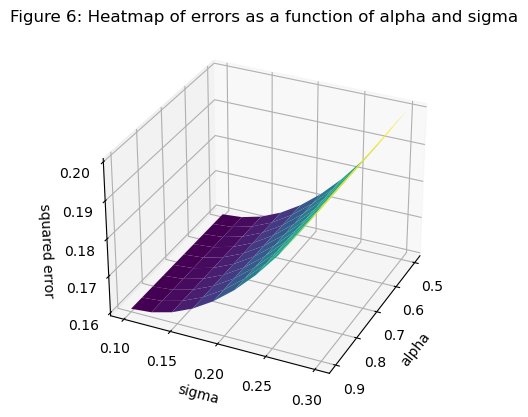

In [13]:
# create 3D plot 
alpha_mesh, sigma_mesh = np.meshgrid(alpha_vals, sigma_vals, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, sigma_mesh, errors, cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('squared error')
ax.set_title("Figure 6: Heatmap of errors as a function of alpha and sigma")

ax.view_init(elev=30, azim=25)  
plt.show()

By holding the $\alpha$ value fixed at 0,5, the resulting figure is incorrect, and can not help match the data.